<a href="https://colab.research.google.com/github/sheepjun96/Hands_On-Maching-Learning/blob/main/11%EC%9E%A5_%EC%8B%AC%EC%B8%B5_%EC%8B%A0%EA%B2%BD%EB%A7%9D_%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


# 11.1 그레이디언트 소실과 폭주 문제

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)
z[::10]

array([-5.        , -4.49748744, -3.99497487, -3.49246231, -2.98994975,
       -2.48743719, -1.98492462, -1.48241206, -0.9798995 , -0.47738693,
        0.02512563,  0.52763819,  1.03015075,  1.53266332,  2.03517588,
        2.53768844,  3.04020101,  3.54271357,  4.04522613,  4.54773869])

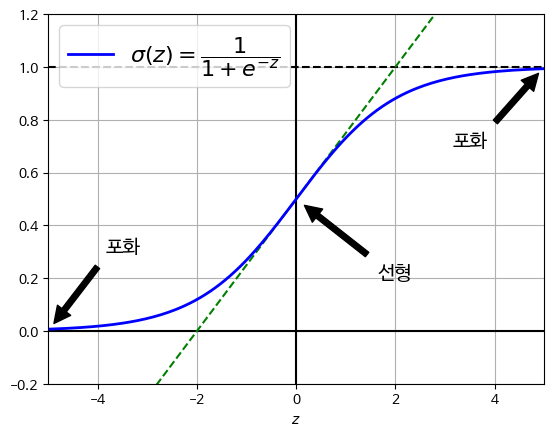

In [3]:
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('포화', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('포화', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('선형', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()

# 글로럿과 He 초기화

In [4]:
import tensorflow as tf

dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

fan_in 대신 fan_avg을 기반으로 He 초기화

In [5]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

# 고급 활성화 함수

# LeakyReLU

In [6]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

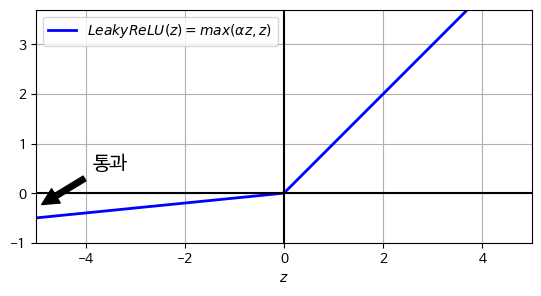

In [7]:
z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('통과', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [8]:
# LeakyReLU를 별도의 층으로 모델에 추가할 수 있다.
model = tf.keras.models.Sequential([
    # [...]  # 다른 층
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # 활성화 함수 없음
    tf.keras.layers.LeakyReLU(alpha=0.2),  # 별도의 층으로 활성화 함수 추가
    # [...]  # 다른 층
])

# ELU

In [9]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

# SELU

기본적으로 SELU 하이퍼파라미터(scale 및 alpha)는 각 뉴런의 평균 출력이 0, 표준편차가 1에 가깝게 유지되도록 튜닝됩니다(책에서 설명한 대로 입력도 평균 0과 표준편차 1로 표준화되고 다른 제약 조건이 준수된다고 가정합니다). 이 활성화 함수를 사용하면 1,000개 층을 가진 심층 신경망에서도 모든 층에서 대략 평균 0과 표준편차 1을 유지하여 기울기가 폭주/소멸하는 문제를 피할 수 있습니다:

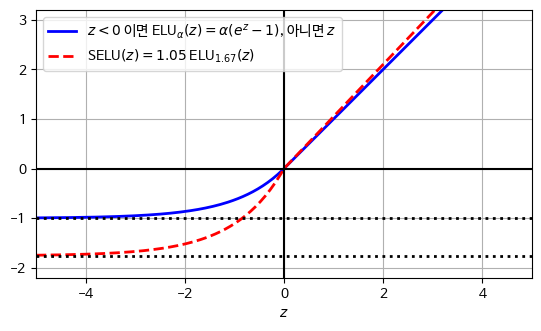

In [10]:
from scipy.special import erfc

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"$z < 0$ 이면 ELU$_\alpha(z) = \alpha (e^z - 1)$, 아니면 $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

SELU를 사용한 자기 정규화된 네트워크의 예시

In [11]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [13]:
# 입력값을 평균 0, 표준편차 1로 스케일해야 한다.
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [14]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train/255, X_valid/255, X_test/255

In [15]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [16]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [17]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 50s 24ms/step - loss: 1.3295 - accuracy: 0.4864 - val_loss: 1.0058 - val_accuracy: 0.6120
Epoch 2/5
1719/1719 [==============================] - 36s 21ms/step - loss: 0.8900 - accuracy: 0.6485 - val_loss: 0.7319 - val_accuracy: 0.7100
Epoch 3/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.7957 - accuracy: 0.6848 - val_loss: 0.6974 - val_accuracy: 0.7156
Epoch 4/5
1719/1719 [==============================] - 39s 22ms/step - loss: 0.6680 - accuracy: 0.7253 - val_loss: 0.6235 - val_accuracy: 0.7646
Epoch 5/5
1719/1719 [==============================] - 40s 23ms/step - loss: 0.6128 - accuracy: 0.7563 - val_loss: 0.6227 - val_accuracy: 0.7674


매우 깊은 신경망인데도 학습에 성공했다.

ReLU 활성화 함수를 대신 사용하면 어떻게 될까?

In [18]:
tf.random.set_seed(42)

In [19]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [20]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [21]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 44s 21ms/step - loss: 1.9323 - accuracy: 0.2340 - val_loss: 1.6809 - val_accuracy: 0.3418
Epoch 2/5
1719/1719 [==============================] - 37s 22ms/step - loss: 1.3595 - accuracy: 0.4401 - val_loss: 1.0608 - val_accuracy: 0.5658
Epoch 3/5
1719/1719 [==============================] - 36s 21ms/step - loss: 1.1099 - accuracy: 0.5226 - val_loss: 0.9655 - val_accuracy: 0.5758
Epoch 4/5
1719/1719 [==============================] - 53s 31ms/step - loss: 0.9898 - accuracy: 0.5722 - val_loss: 0.8520 - val_accuracy: 0.6662
Epoch 5/5
1719/1719 [==============================] - 42s 25ms/step - loss: 0.8506 - accuracy: 0.6548 - val_loss: 0.8477 - val_accuracy: 0.6828


그레이디언트 소멸/폭주 문제를 겪는다.

# GELU, Swish, Mish

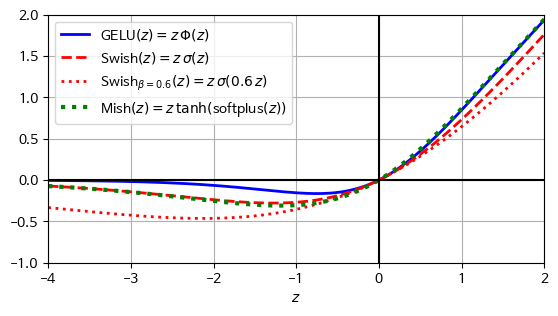

In [22]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

plt.show()

# 배치 정규화

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [26]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

# 그레이디언트 클리핑

모든 tf.keras.optimizers는 clipnorm 또는 clipvalue 매개변수를 받습니다

In [27]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [28]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

# 11.2 사전 훈련된 층 재사용하기

# 케라스를 사용한 전이 학습

패션 MNIST 훈련 집합을 두 개로 나눠 보겠습니다:

X_train_A: T-shirts/tops와 pullovers를 제외한 모든 항목의 모든 이미지 (클래스 0과 2).
X_train_B: T-shirts/tops와 pullovers 중에서 처음 200개의 이미지로만 구성된 훨씬 작은 훈련 세트.
검증 세트와 테스트 세트도 이러한 방식으로 분할되지만 이미지 수에는 제한이 없습니다.

집합 A(8개의 클래스가 있는 분류 작업)에 대해 모델을 훈련하고, 이를 다시 집합 B(이진 분류)를 처리하는 데 사용하려고 합니다. 집합 A의 클래스(trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots)는 집합 B의 클래스(T-shirts/tops, pullovers)과 다소 유사하므로, 작업 A에서 작업 B로 약간의 지식이 전이되기를 희망합니다.

그러나 Dense 층을 사용하기 때문에 같은 위치에서 발생하는 패턴만 재사용할 수 있습니다(하지만 14장에서 살펴볼 합성곱 층은 학습된 패턴을 이미지의 어느 위치에서나 감지할 수 있습니다).

In [29]:
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # A에 대한 클래스 ID 재정의
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 7s 5ms/step - loss: 1.1616 - accuracy: 0.6335 - val_loss: 0.7174 - val_accuracy: 0.7689
Epoch 2/20
1376/1376 [==============================] - 9s 7ms/step - loss: 0.6240 - accuracy: 0.7954 - val_loss: 0.5352 - val_accuracy: 0.8255
Epoch 3/20
1376/1376 [==============================] - 7s 5ms/step - loss: 0.5043 - accuracy: 0.8393 - val_loss: 0.4575 - val_accuracy: 0.8448
Epoch 4/20
1376/1376 [==============================] - 8s 6ms/step - loss: 0.4409 - accuracy: 0.8588 - val_loss: 0.4091 - val_accuracy: 0.8639
Epoch 5/20
1376/1376 [==============================] - 8s 6ms/step - loss: 0.4014 - accuracy: 0.8690 - val_loss: 0.3794 - val_accuracy: 0.8694
Epoch 6/20
1376/1376 [==============================] - 6s 5ms/step - loss: 0.3739 - accuracy: 0.8762 - val_loss: 0.3591 - val_accuracy: 0.8789
Epoch 7/20
1376/1376 [==============================] - 10s 8ms/step - loss: 0.3544 - accuracy: 0.8814 - val_loss: 0.3419 - val_accuracy

In [30]:
tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 2s 108ms/step - loss: 0.7109 - accuracy: 0.5550 - val_loss: 0.6951 - val_accuracy: 0.5302
Epoch 2/20
7/7 [==============================] - 0s 39ms/step - loss: 0.6554 - accuracy: 0.5650 - val_loss: 0.6513 - val_accuracy: 0.5539
Epoch 3/20
7/7 [==============================] - 0s 65ms/step - loss: 0.6184 - accuracy: 0.6050 - val_loss: 0.6225 - val_accuracy: 0.5865
Epoch 4/20
7/7 [==============================] - 0s 23ms/step - loss: 0.5902 - accuracy: 0.6600 - val_loss: 0.5970 - val_accuracy: 0.6805
Epoch 5/20
7/7 [==============================] - 0s 32ms/step - loss: 0.5666 - accuracy: 0.7400 - val_loss: 0.5743 - val_accuracy: 0.7814
Epoch 6/20
7/7 [==============================] - 0s 29ms/step - loss: 0.5450 - accuracy: 0.8350 - val_loss: 0.5542 - val_accuracy: 0.8467
Epoch 7/20
7/7 [==============================] - 0s 36ms/step - loss: 0.5253 - accuracy: 0.8900 - val_loss: 0.5366 - val_accuracy: 0.8872
Epoch 8/20
7/7 [==========

[0.4049643874168396, 0.9254999756813049]

샌들과 셔츠 이미지를 구분하는 모델 B는 91.85%의 정확도를 가진다.

모델 A를 로드하고 이 모델의 층을 기반으로 새로운 모델 model_B_on_A를 만든다. 출력 층만 제외하고 모든 층을 재사용한다.

In [31]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [32]:
tf.random.set_seed(42)

model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [33]:
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [34]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [35]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 65ms/step - loss: 1.0716 - accuracy: 0.4450 - val_loss: 0.6938 - val_accuracy: 0.4926
Epoch 2/4
7/7 [==============================] - 0s 35ms/step - loss: 0.6137 - accuracy: 0.6100 - val_loss: 0.5237 - val_accuracy: 0.8200
Epoch 3/4
7/7 [==============================] - 0s 34ms/step - loss: 0.5095 - accuracy: 0.8500 - val_loss: 0.4993 - val_accuracy: 0.8754
Epoch 4/4
7/7 [==============================] - 0s 34ms/step - loss: 0.4886 - accuracy: 0.8900 - val_loss: 0.4934 - val_accuracy: 0.8813
Epoch 1/16
7/7 [==============================] - 1s 84ms/step - loss: 0.4721 - accuracy: 0.9000 - val_loss: 0.4678 - val_accuracy: 0.8734
Epoch 2/16
7/7 [==============================] - 0s 32ms/step - loss: 0.4439 - accuracy: 0.9050 - val_loss: 0.4336 - val_accuracy: 0.9070
Epoch 3/16
7/7 [==============================] - 0s 18ms/step - loss: 0.4129 - accuracy: 0.9250 - val_loss: 0.4156 - val_accuracy: 0.9130
Epoch 4/16
7/7 [===============

In [36]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 4ms/step - loss: 0.2822 - accuracy: 0.9335


[0.2821941077709198, 0.9334999918937683]

# 11.3 고속 옵티마이저

In [37]:
# 패션 MNIST에서 옵티마이저를 테스트하는 간단한 함수

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

In [38]:
def build_and_train_model(optimizer):   # 옵티마이저 입력
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
              validation_data=(X_valid, y_valid), verbose=0)

In [39]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [40]:
history_sgd = build_and_train_model(optimizer)

313/313 [==============================] - 1s 4ms/step - loss: 0.3839 - accuracy: 0.8605


# 모멘텀 최적화

In [41]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [42]:
history_momentum = build_and_train_model(optimizer)

313/313 [==============================] - 1s 4ms/step - loss: 0.3840 - accuracy: 0.8640


# 네스테로프 가속 경사

In [43]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [44]:
history_nesterov = build_and_train_model(optimizer)

313/313 [==============================] - 1s 2ms/step - loss: 0.3814 - accuracy: 0.8625


# AdaGrad

In [45]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [46]:
history_adagrad = build_and_train_model(optimizer)

313/313 [==============================] - 1s 2ms/step - loss: 0.4869 - accuracy: 0.8310


# RMSProp

In [47]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [48]:
history_rmsprop = build_and_train_model(optimizer)

313/313 [==============================] - 1s 3ms/step - loss: 0.5178 - accuracy: 0.8673


# Adam

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [50]:
history_adam = build_and_train_model(optimizer)

313/313 [==============================] - 1s 3ms/step - loss: 0.3744 - accuracy: 0.8748


# Adamax

In [51]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [52]:
history_adamax = build_and_train_model(optimizer)

313/313 [==============================] - 1s 3ms/step - loss: 0.3600 - accuracy: 0.8697


# Nadam

In [53]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [54]:
history_nadam = build_and_train_model(optimizer)

313/313 [==============================] - 2s 5ms/step - loss: 0.3732 - accuracy: 0.8751


# AdamW

Colab 또는 Kaggle에서는 TensorFlow-Addons 라이브러리를 설치해야 한다

In [55]:
if "google.colab" in sys.modules:
    %pip install -q -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.0 MB/s eta 0:00:00


In [56]:
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [57]:
history_adamw = build_and_train_model(optimizer)

313/313 [==============================] - 1s 2ms/step - loss: 0.3456 - accuracy: 0.8726


# 학습률 스케줄링

거듭제곱 기반 스케줄링

lr = lr0 / (1 + steps / s)**c

케라스는 c=1과 s = 1 / decay를 사용합니다.

In [76]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, weight_decay=1e-4)

In [77]:
history_power_scheduling = build_and_train_model(optimizer)

313/313 [==============================] - 1s 3ms/step - loss: 0.3765 - accuracy: 0.8657


In [78]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
n_epochs = 25

epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

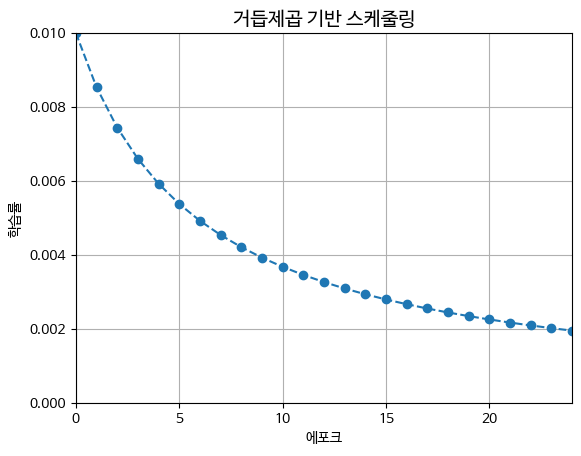

In [79]:
plt.plot(epochs, lrs, "o--")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("에포크")
plt.ylabel("학습률")
plt.title("거듭제곱 기반 스케줄링", fontsize=14)
plt.grid(True)
plt.show()

지수 기반 스케줄링

lr = lr0 * 0.1 ** (epoch / s)

In [89]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [90]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [91]:
# 패션 MNIST용 모델 빌드 및 컴파일

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [93]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler], verbose=0)

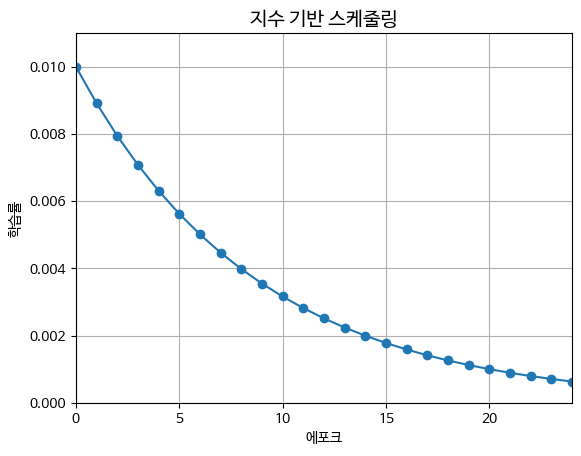

In [94]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("에포크")
plt.ylabel("학습률")
plt.title("지수 기반 스케줄링", fontsize=14)
plt.grid(True)
plt.show()

구간별 고정 스케줄링

In [95]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [98]:
# 구간별 고정 스케줄링을 정의하는 일반적인 방법

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [101]:
n_epochs = 25
lr0 = 0.01

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler], verbose=0)

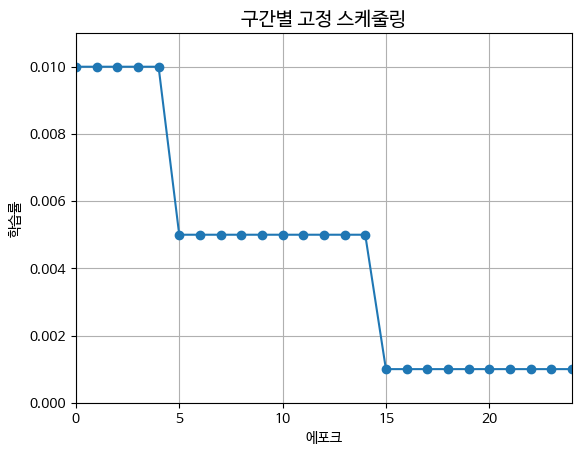

In [102]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("에포크")
plt.ylabel("학습률")
plt.title("구간별 고정 스케줄링", fontsize=14)
plt.grid(True)
plt.show()

성능 기반 스케줄링

In [103]:
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [104]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler], verbose=0)

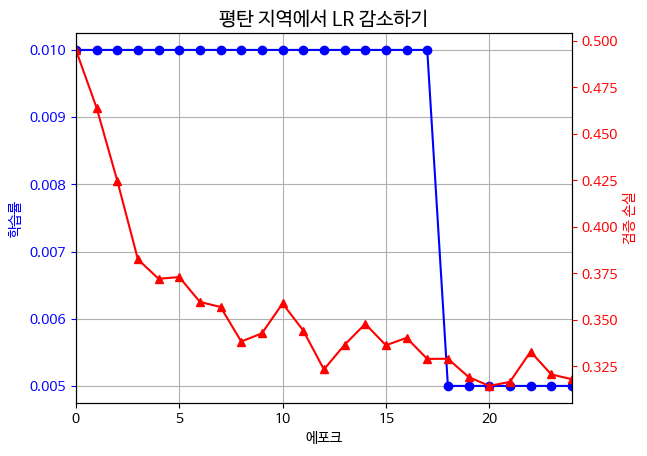

In [105]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("에포크")
plt.ylabel("학습률", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('검증 손실', color='r')
ax2.tick_params('y', colors='r')

plt.title("평탄 지역에서 LR 감소하기", fontsize=14)
plt.show()

# 11.4 규제를 사용해 과대적합 피하기

l1과 l2 규제

In [106]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

In [107]:
tf.random.set_seed(42)

In [108]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

In [109]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [97]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 3ms/step - loss: 0.3402 - accuracy: 0.8756 - val_loss: 0.3596 - val_accuracy: 0.8712
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3185 - accuracy: 0.8846 - val_loss: 0.3890 - val_accuracy: 0.8490


드롭아웃

In [110]:
tf.random.set_seed(42)

In [111]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [112]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid), verbose=0)

In [113]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3180 - accuracy: 0.8825


[0.3179911971092224, 0.8825091123580933]

In [114]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3727 - accuracy: 0.8643


[0.37266653776168823, 0.864300012588501]

몬테 카를로 드롭아웃

In [115]:
tf.random.set_seed(42)

In [116]:
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [117]:
model.predict(X_test[:1]).round(3)

1/1 [==============================] - 0s 118ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.011, 0.   , 0.219, 0.   ,
        0.771]], dtype=float32)

In [118]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.031, 0.   , 0.244, 0.002,
       0.722], dtype=float32)

In [119]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [120]:
# 추가 코드 - 시퀀셜 모델에서 Dropout을 MCDropout으로 변환하는 방법을 보여줍니다.
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [121]:
mc_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_82 (Dense)            (None, 100)               78500     
                                                                 
 mc_dropout_1 (MCDropout)    (None, 100)               0         
                                                                 
 dense_83 (Dense)            (None, 100)               10100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_84 (Dense)            (None, 10)              

맥스-노름 규제

In [122]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [123]:
# 모델의 모든 은닉층에 맥스-노름을 적용하는 방법을 보여줍니다.
MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid), verbose=0)